## Customer Churn Modelling using H2OAutoML

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "20" 2023-03-21; OpenJDK Runtime Environment Zulu20.28+85-CA (build 20+36); OpenJDK 64-Bit Server VM Zulu20.28+85-CA (build 20+36, mixed mode, sharing)
  Starting server from /Users/Michael_Enudi/opt/anaconda3/envs/h2o_env/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/tmpd_7uyq4a
  JVM stdout: /var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/tmpd_7uyq4a/h2o_Michael_Enudi_started_from_python.out
  JVM stderr: /var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/tmpd_7uyq4a/h2o_Michael_Enudi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Africa/Johannesburg
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_Michael_Enudi_gp8ztx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


### Data Ingestion

In [2]:
data = pd.read_csv('../../data/Customer_Churn_Dataset.csv')
print(data.shape)
data.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# we can agree that RowNumber, CustomerId and Surnameoffer no predictive values. So we will remove them
label = 'Exited'
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
data[label] = data[label].astype('category')
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Data analysis

In [4]:
# summary statistics
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


([<matplotlib.patches.Wedge at 0x7fcc5048d040>,
 [Text(-0.8823431426537007, 0.6568642010431011, ''),
  Text(0.8823431426537006, -0.6568642010431012, '')])

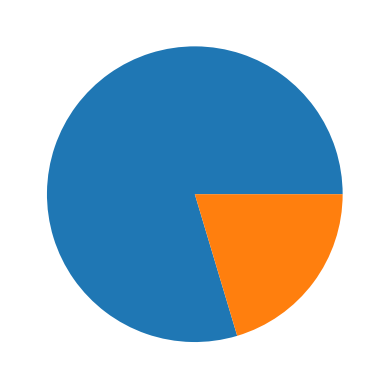

In [6]:
# distribution of exited classes
plt.pie(data[label].value_counts())

### Model training

In [7]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [8]:
multi_col_label_encoder = MultiColumnLabelEncoder(columns=['Geography', 'Gender', 'Age'])
data[['Geography', 'Gender', 'Age']] = multi_col_label_encoder.transform(data[['Geography', 'Gender', 'Age']])
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,24,2,0.00,1,1,1,101348.88,1
1,608,2,0,23,1,83807.86,1,0,1,112542.58,0
2,502,0,0,24,8,159660.80,3,1,0,113931.57,1
3,699,0,0,21,1,0.00,2,0,0,93826.63,0
4,850,2,0,25,2,125510.82,1,1,1,79084.10,0


In [9]:
## split test and train as well as dep and indep variable
# Identify predictors and response
Xs = [x for x in data.columns if x != label]

stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=1)
for i, (train_index, test_index) in enumerate(stratified_shuffle_split.split(data,data[label])):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
train_frame = h2o.H2OFrame(train)
train_frame[label] = train_frame[label].asfactor()

test_frame = h2o.H2OFrame(test.drop(columns=[label]))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [10]:
aml = H2OAutoML(seed=1)
aml.train(x=Xs, y=label, training_frame=train_frame)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [11]:
lb = aml.leaderboard
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_4_AutoML_1_20230608_223328,0.86676,0.333675,0.702082,0.226916,0.319016,0.101771
StackedEnsemble_BestOfFamily_6_AutoML_1_20230608_223328,0.866581,0.333672,0.702222,0.232393,0.319067,0.101804
StackedEnsemble_AllModels_3_AutoML_1_20230608_223328,0.866044,0.333712,0.703176,0.226466,0.318758,0.101607
StackedEnsemble_AllModels_6_AutoML_1_20230608_223328,0.865244,0.334374,0.70283,0.225048,0.318987,0.101752
StackedEnsemble_AllModels_4_AutoML_1_20230608_223328,0.86498,0.334634,0.701868,0.228805,0.319124,0.10184
StackedEnsemble_Best1000_1_AutoML_1_20230608_223328,0.864702,0.334735,0.702257,0.229181,0.319191,0.101883
StackedEnsemble_AllModels_2_AutoML_1_20230608_223328,0.864598,0.335184,0.701043,0.220135,0.319432,0.102037
GBM_grid_1_AutoML_1_20230608_223328_model_9,0.864072,0.337439,0.697235,0.225067,0.320576,0.102769
XGBoost_lr_search_selection_AutoML_1_20230608_223328_select_grid_model_3,0.863887,0.338483,0.692279,0.226667,0.320947,0.103007
XGBoost_grid_1_AutoML_1_20230608_223328_model_15,0.863838,0.338594,0.692488,0.22453,0.320955,0.103012


In [12]:
# best_model = aml.get_best_model() 
# # Get the best model using a non-default metric
# best_model = aml.get_best_model(criterion="logloss")
# # Get the best XGBoost model using default sort metric
# best_xgb_model = aml.get_best_model(algorithm="xgboost")
# # Get the best XGBoost model, ranked by logloss
# best_xgb_model = aml.get_best_model(algorithm="xgboost", criterion="logloss")
# # Get a specific model by model ID
# best_model = h2o.get_model("StackedEnsemble_BestOfFamily_AutoML_20191213_174603")

best_model = aml.leader # equivalent of aml.get_best_model() 


### Testing and evaluation

In [28]:
y_prediction = best_model.predict(test_frame)
y_class_pred = y_prediction['predict'].as_data_frame()['predict']

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [29]:
def display_metrics(y_true, y_pred):
    print("Accuracy score:", round(accuracy_score(y_true, y_pred),4))
    print("Precision score:", round(precision_score(y_true, y_pred),4))
    print("Recall score:", round(recall_score(y_true, y_pred),4))
    print("F1 score:", round(f1_score(y_true, y_pred),4))
    print("Confusion matrix \n")
    print(confusion_matrix(y_true=y_true, y_pred=y_pred))
    
display_metrics(test[label], y_class_pred)

Accuracy score: 0.8453
Precision score: 0.6178
Recall score: 0.634
F1 score: 0.6258
Confusion matrix 

[[1074  120]
 [ 112  194]]


### Model explainability

In [33]:
best_model.explain(test_frame)

### persist model to disk

In [35]:
best_model.save_model_details(...)

Signature: best_model.save_model_details(path='', force=False, filename=None)
Docstring:
Save Model Details of an H2O Model in JSON Format to disk.

:param path: a path to save the model details at (e.g. hdfs, s3, local).
:param force: if ``True``, overwrite destination directory in case it exists, or throw exception if set to ``False``.
:param filename: a filename for the saved model (file type is always .json).

:returns str: the path of the saved model details
File:      ~/opt/anaconda3/envs/h2o_env/lib/python3.8/site-packages/h2o/model/model_base.py
Type:      method